# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 uncertainty-adjusted topics most highly correlated with GDP growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast GDP growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 uncertainty-adjusted topics (<=2007, 200 topics, all sources).
- **Forecast Target:** GDP growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'GDP'                             # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11678
EM converged at iteration 64, llf=-11441, convergence criterion=9.8298e-07 < tolerance=1e-06
EM start iterations, llf=-11691
EM converged at iteration 64, llf=-11453, convergence criterion=9.8186e-07 < tolerance=1e-06
EM start iterations, llf=-11749
EM converged at iteration 64, llf=-11508, convergence criterion=9.8318e-07 < tolerance=1e-06
EM start iterations, llf=-11757
EM converged at iteration 64, llf=-11517, convergence criterion=9.919e-07 < tolerance=1e-06
EM start iterations, llf=-11820
EM converged at iteration 64, llf=-11574, convergence criterion=9.8355e-07 < tolerance=1e-06
EM start iterations, llf=-11828
EM converged at iteration 64, llf=-11581, convergence criterion=9.8169e-07 < tolerance=1e-06
EM start iterations, llf=-11884
EM converged at iteration 64, llf=-11637, convergence criterion=9.8396e-07 < tolerance=1e-06
EM start iterations, llf=-11884
EM converged at iteration 64, llf=-11637, convergence criterion=9.8396e-07 < tolerance=1e-06
E

EM start iterations, llf=-13351
EM converged at iteration 42, llf=-13160, convergence criterion=9.6268e-07 < tolerance=1e-06
EM start iterations, llf=-13426
EM converged at iteration 39, llf=-13245, convergence criterion=9.8427e-07 < tolerance=1e-06
EM start iterations, llf=-13432
EM converged at iteration 41, llf=-13249, convergence criterion=9.8272e-07 < tolerance=1e-06
EM start iterations, llf=-13484
EM converged at iteration 42, llf=-13297, convergence criterion=9.6979e-07 < tolerance=1e-06
EM start iterations, llf=-13484
EM converged at iteration 42, llf=-13297, convergence criterion=9.6979e-07 < tolerance=1e-06
EM start iterations, llf=-13496
EM converged at iteration 42, llf=-13310, convergence criterion=9.9062e-07 < tolerance=1e-06
EM start iterations, llf=-13554
EM converged at iteration 42, llf=-13370, convergence criterion=9.6052e-07 < tolerance=1e-06
EM start iterations, llf=-13560
EM converged at iteration 43, llf=-13376, convergence criterion=9.966e-07 < tolerance=1e-06
E

EM start iterations, llf=-15066
EM converged at iteration 46, llf=-14864, convergence criterion=9.6339e-07 < tolerance=1e-06
EM start iterations, llf=-15066
EM converged at iteration 46, llf=-14864, convergence criterion=9.6339e-07 < tolerance=1e-06
EM start iterations, llf=-15075
EM converged at iteration 46, llf=-14874, convergence criterion=9.6306e-07 < tolerance=1e-06
EM start iterations, llf=-15130
EM converged at iteration 45, llf=-14929, convergence criterion=9.9218e-07 < tolerance=1e-06
EM start iterations, llf=-15142
EM converged at iteration 46, llf=-14942, convergence criterion=9.6338e-07 < tolerance=1e-06
EM start iterations, llf=-15194
EM converged at iteration 46, llf=-14992, convergence criterion=9.6237e-07 < tolerance=1e-06
EM start iterations, llf=-15201
EM converged at iteration 46, llf=-14999, convergence criterion=9.6083e-07 < tolerance=1e-06
EM start iterations, llf=-15248
EM converged at iteration 46, llf=-15044, convergence criterion=9.63e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16766
EM converged at iteration 39, llf=-16535, convergence criterion=9.9507e-07 < tolerance=1e-06
EM start iterations, llf=-16773
EM converged at iteration 40, llf=-16542, convergence criterion=9.5271e-07 < tolerance=1e-06
EM start iterations, llf=-16824
EM converged at iteration 39, llf=-16594, convergence criterion=9.9019e-07 < tolerance=1e-06
EM start iterations, llf=-16831
EM converged at iteration 39, llf=-16600, convergence criterion=9.9567e-07 < tolerance=1e-06
EM start iterations, llf=-16889
EM converged at iteration 39, llf=-16658, convergence criterion=9.8587e-07 < tolerance=1e-06
EM start iterations, llf=-16889
EM converged at iteration 39, llf=-16658, convergence criterion=9.8587e-07 < tolerance=1e-06
EM start iterations, llf=-16898
EM converged at iteration 39, llf=-16667, convergence criterion=9.7377e-07 < tolerance=1e-06
EM start iterations, llf=-16948
EM converged at iteration 39, llf=-16717, convergence criterion=9.597e-07 < tolerance=1e-06
E

EM start iterations, llf=-18279
EM converged at iteration 39, llf=-18035, convergence criterion=9.8683e-07 < tolerance=1e-06
EM start iterations, llf=-18338
EM converged at iteration 39, llf=-18092, convergence criterion=9.8857e-07 < tolerance=1e-06
EM start iterations, llf=-18338
EM converged at iteration 39, llf=-18092, convergence criterion=9.8857e-07 < tolerance=1e-06
EM start iterations, llf=-18344
EM converged at iteration 39, llf=-18097, convergence criterion=9.8852e-07 < tolerance=1e-06
EM start iterations, llf=-18397
EM converged at iteration 39, llf=-18149, convergence criterion=9.9001e-07 < tolerance=1e-06
EM start iterations, llf=-18405
EM converged at iteration 40, llf=-18157, convergence criterion=9.7943e-07 < tolerance=1e-06
EM start iterations, llf=-18459
EM converged at iteration 40, llf=-18210, convergence criterion=9.8009e-07 < tolerance=1e-06
EM start iterations, llf=-18466
EM converged at iteration 40, llf=-18218, convergence criterion=9.793e-07 < tolerance=1e-06
E

EM start iterations, llf=-12228
EM converged at iteration 63, llf=-11964, convergence criterion=9.7912e-07 < tolerance=1e-06
EM start iterations, llf=-12211
EM converged at iteration 62, llf=-11944, convergence criterion=9.83e-07 < tolerance=1e-06
EM start iterations, llf=-12276
EM converged at iteration 61, llf=-12013, convergence criterion=9.7347e-07 < tolerance=1e-06
EM start iterations, llf=-12296
EM converged at iteration 66, llf=-12041, convergence criterion=9.8563e-07 < tolerance=1e-06
EM start iterations, llf=-12286
EM converged at iteration 67, llf=-12057, convergence criterion=9.9987e-07 < tolerance=1e-06
EM start iterations, llf=-12285
EM converged at iteration 67, llf=-12054, convergence criterion=9.845e-07 < tolerance=1e-06
EM start iterations, llf=-12294
EM converged at iteration 65, llf=-12071, convergence criterion=9.9998e-07 < tolerance=1e-06
EM start iterations, llf=-12294
EM converged at iteration 65, llf=-12071, convergence criterion=9.9998e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-13902
EM converged at iteration 71, llf=-13705, convergence criterion=9.8099e-07 < tolerance=1e-06
EM start iterations, llf=-13936
EM converged at iteration 69, llf=-13731, convergence criterion=9.7479e-07 < tolerance=1e-06
EM start iterations, llf=-13941
EM converged at iteration 71, llf=-13743, convergence criterion=9.7617e-07 < tolerance=1e-06
EM start iterations, llf=-13990
EM converged at iteration 75, llf=-13800, convergence criterion=9.9396e-07 < tolerance=1e-06
EM start iterations, llf=-13990
EM converged at iteration 75, llf=-13800, convergence criterion=9.9396e-07 < tolerance=1e-06
EM start iterations, llf=-14000
EM converged at iteration 75, llf=-13811, convergence criterion=9.9522e-07 < tolerance=1e-06
EM start iterations, llf=-14055
EM converged at iteration 75, llf=-13864, convergence criterion=9.7635e-07 < tolerance=1e-06
EM start iterations, llf=-14062
EM converged at iteration 72, llf=-13871, convergence criterion=9.837e-07 < tolerance=1e-06
E

EM start iterations, llf=-15615
EM converged at iteration 68, llf=-15398, convergence criterion=9.8035e-07 < tolerance=1e-06
EM start iterations, llf=-15615
EM converged at iteration 68, llf=-15398, convergence criterion=9.8035e-07 < tolerance=1e-06
EM start iterations, llf=-15623
EM converged at iteration 67, llf=-15407, convergence criterion=9.8713e-07 < tolerance=1e-06
EM start iterations, llf=-15678
EM converged at iteration 67, llf=-15460, convergence criterion=9.8336e-07 < tolerance=1e-06
EM start iterations, llf=-15681
EM converged at iteration 66, llf=-15463, convergence criterion=9.9444e-07 < tolerance=1e-06
EM start iterations, llf=-15734
EM converged at iteration 67, llf=-15515, convergence criterion=9.8046e-07 < tolerance=1e-06
EM start iterations, llf=-15738
EM converged at iteration 67, llf=-15519, convergence criterion=9.7626e-07 < tolerance=1e-06
EM start iterations, llf=-15783
EM converged at iteration 67, llf=-15564, convergence criterion=9.7956e-07 < tolerance=1e-06


EM start iterations, llf=-17307
EM converged at iteration 58, llf=-17079, convergence criterion=9.7589e-07 < tolerance=1e-06
EM start iterations, llf=-17314
EM converged at iteration 58, llf=-17086, convergence criterion=9.8423e-07 < tolerance=1e-06
EM start iterations, llf=-17370
EM converged at iteration 58, llf=-17141, convergence criterion=9.7742e-07 < tolerance=1e-06
EM start iterations, llf=-17378
EM converged at iteration 58, llf=-17148, convergence criterion=9.7748e-07 < tolerance=1e-06
EM start iterations, llf=-17426
EM converged at iteration 58, llf=-17195, convergence criterion=9.8237e-07 < tolerance=1e-06
EM start iterations, llf=-17426
EM converged at iteration 58, llf=-17195, convergence criterion=9.8237e-07 < tolerance=1e-06
EM start iterations, llf=-17445
EM converged at iteration 58, llf=-17214, convergence criterion=9.8409e-07 < tolerance=1e-06
EM start iterations, llf=-17496
EM converged at iteration 57, llf=-17266, convergence criterion=9.8507e-07 < tolerance=1e-06


EM start iterations, llf=-18814
EM converged at iteration 59, llf=-18555, convergence criterion=9.8498e-07 < tolerance=1e-06
EM start iterations, llf=-18863
EM converged at iteration 58, llf=-18604, convergence criterion=9.9974e-07 < tolerance=1e-06
EM start iterations, llf=-18863
EM converged at iteration 58, llf=-18604, convergence criterion=9.9974e-07 < tolerance=1e-06
EM start iterations, llf=-18871
EM converged at iteration 58, llf=-18613, convergence criterion=9.9943e-07 < tolerance=1e-06
EM start iterations, llf=-18927
EM converged at iteration 58, llf=-18670, convergence criterion=9.9575e-07 < tolerance=1e-06
EM start iterations, llf=-18936
EM converged at iteration 59, llf=-18679, convergence criterion=9.764e-07 < tolerance=1e-06
EM start iterations, llf=-18990
EM converged at iteration 59, llf=-18732, convergence criterion=9.7537e-07 < tolerance=1e-06
EM start iterations, llf=-18999
EM converged at iteration 59, llf=-18740, convergence criterion=9.7389e-07 < tolerance=1e-06
E

EM converged at iteration 65, llf=-12438, convergence criterion=9.9078e-07 < tolerance=1e-06
EM start iterations, llf=-12653
EM converged at iteration 65, llf=-12444, convergence criterion=9.8539e-07 < tolerance=1e-06
EM start iterations, llf=-12707
EM converged at iteration 65, llf=-12496, convergence criterion=9.6896e-07 < tolerance=1e-06
EM start iterations, llf=-12715
EM converged at iteration 63, llf=-12505, convergence criterion=9.7544e-07 < tolerance=1e-06
EM start iterations, llf=-12758
EM converged at iteration 61, llf=-12541, convergence criterion=9.9691e-07 < tolerance=1e-06
EM start iterations, llf=-12769
EM converged at iteration 61, llf=-12551, convergence criterion=9.9202e-07 < tolerance=1e-06
EM start iterations, llf=-12833
EM converged at iteration 62, llf=-12623, convergence criterion=9.9367e-07 < tolerance=1e-06
EM start iterations, llf=-12833
EM converged at iteration 62, llf=-12623, convergence criterion=9.9367e-07 < tolerance=1e-06
EM start iterations, llf=-12844


EM start iterations, llf=-14397
EM converged at iteration 67, llf=-14199, convergence criterion=9.8074e-07 < tolerance=1e-06
EM start iterations, llf=-14447
EM converged at iteration 67, llf=-14254, convergence criterion=9.9665e-07 < tolerance=1e-06
EM start iterations, llf=-14456
EM converged at iteration 67, llf=-14259, convergence criterion=9.9144e-07 < tolerance=1e-06
EM start iterations, llf=-14509
EM converged at iteration 68, llf=-14315, convergence criterion=9.7545e-07 < tolerance=1e-06
EM start iterations, llf=-14509
EM converged at iteration 68, llf=-14315, convergence criterion=9.7545e-07 < tolerance=1e-06
EM start iterations, llf=-14517
EM converged at iteration 67, llf=-14321, convergence criterion=9.9739e-07 < tolerance=1e-06
EM start iterations, llf=-14572
EM converged at iteration 67, llf=-14375, convergence criterion=9.9329e-07 < tolerance=1e-06
EM start iterations, llf=-14582
EM converged at iteration 69, llf=-14384, convergence criterion=9.8007e-07 < tolerance=1e-06


EM start iterations, llf=-16149
EM converged at iteration 66, llf=-15930, convergence criterion=9.8732e-07 < tolerance=1e-06
EM start iterations, llf=-16149
EM converged at iteration 66, llf=-15930, convergence criterion=9.8732e-07 < tolerance=1e-06
EM start iterations, llf=-16158
EM converged at iteration 66, llf=-15939, convergence criterion=9.8937e-07 < tolerance=1e-06
EM start iterations, llf=-16211
EM converged at iteration 66, llf=-15990, convergence criterion=9.8437e-07 < tolerance=1e-06
EM start iterations, llf=-16221
EM converged at iteration 66, llf=-16000, convergence criterion=9.8722e-07 < tolerance=1e-06
EM start iterations, llf=-16269
EM converged at iteration 66, llf=-16047, convergence criterion=9.8227e-07 < tolerance=1e-06
EM start iterations, llf=-16276
EM converged at iteration 66, llf=-16054, convergence criterion=9.812e-07 < tolerance=1e-06
EM start iterations, llf=-16327
EM converged at iteration 66, llf=-16104, convergence criterion=9.7886e-07 < tolerance=1e-06
E

EM start iterations, llf=-17859
EM converged at iteration 59, llf=-17619, convergence criterion=9.8974e-07 < tolerance=1e-06
EM start iterations, llf=-17867
EM converged at iteration 60, llf=-17628, convergence criterion=9.7339e-07 < tolerance=1e-06
EM start iterations, llf=-17909
EM converged at iteration 60, llf=-17669, convergence criterion=9.7793e-07 < tolerance=1e-06
EM start iterations, llf=-17916
EM converged at iteration 60, llf=-17676, convergence criterion=9.7775e-07 < tolerance=1e-06
EM start iterations, llf=-17968
EM converged at iteration 60, llf=-17729, convergence criterion=9.9283e-07 < tolerance=1e-06
EM start iterations, llf=-17968
EM converged at iteration 60, llf=-17729, convergence criterion=9.9283e-07 < tolerance=1e-06
EM start iterations, llf=-17972
EM converged at iteration 60, llf=-17732, convergence criterion=9.9209e-07 < tolerance=1e-06
EM start iterations, llf=-18023
EM converged at iteration 60, llf=-17781, convergence criterion=9.8669e-07 < tolerance=1e-06


EM start iterations, llf=-19081
EM converged at iteration 60, llf=-18816, convergence criterion=9.848e-07 < tolerance=1e-06
EM start iterations, llf=-19134
EM converged at iteration 60, llf=-18869, convergence criterion=9.7964e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 3 estimated in 2:15:26.904244.
EM start iterations, llf=-11197
EM converged at iteration 56, llf=-11057, convergence criterion=9.7454e-07 < tolerance=1e-06
EM start iterations, llf=-11210
EM converged at iteration 56, llf=-11070, convergence criterion=9.7326e-07 < tolerance=1e-06
EM start iterations, llf=-11267
EM converged at iteration 56, llf=-11126, convergence criterion=9.7209e-07 < tolerance=1e-06
EM start iterations, llf=-11276
EM converged at iteration 55, llf=-11135, convergence criterion=9.8834e-07 < tolerance=1e-06
EM start iterations, llf=-11331
EM converged at iteration 54, llf=-11191, convergence criterion=9.8176e-07 < tolerance=1e-06
EM start iterations, llf=-11342
EM converged at 

EM start iterations, llf=-12628
EM converged at iteration 32, llf=-12477, convergence criterion=9.6177e-07 < tolerance=1e-06
EM start iterations, llf=-12640
EM converged at iteration 32, llf=-12489, convergence criterion=9.6685e-07 < tolerance=1e-06
EM start iterations, llf=-12671
EM converged at iteration 32, llf=-12519, convergence criterion=9.548e-07 < tolerance=1e-06
EM start iterations, llf=-12679
EM converged at iteration 32, llf=-12524, convergence criterion=9.8982e-07 < tolerance=1e-06
EM start iterations, llf=-12751
EM converged at iteration 33, llf=-12590, convergence criterion=9.5226e-07 < tolerance=1e-06
EM start iterations, llf=-12756
EM converged at iteration 33, llf=-12598, convergence criterion=9.5287e-07 < tolerance=1e-06
EM start iterations, llf=-12798
EM converged at iteration 32, llf=-12640, convergence criterion=9.7047e-07 < tolerance=1e-06
EM start iterations, llf=-12798
EM converged at iteration 32, llf=-12640, convergence criterion=9.7047e-07 < tolerance=1e-06
E

EM start iterations, llf=-14218
EM converged at iteration 32, llf=-14053, convergence criterion=9.6006e-07 < tolerance=1e-06
EM start iterations, llf=-14264
EM converged at iteration 32, llf=-14099, convergence criterion=9.4235e-07 < tolerance=1e-06
EM start iterations, llf=-14272
EM converged at iteration 32, llf=-14106, convergence criterion=9.4459e-07 < tolerance=1e-06
EM start iterations, llf=-14323
EM converged at iteration 32, llf=-14157, convergence criterion=9.5178e-07 < tolerance=1e-06
EM start iterations, llf=-14323
EM converged at iteration 32, llf=-14157, convergence criterion=9.5178e-07 < tolerance=1e-06
EM start iterations, llf=-14331
EM converged at iteration 32, llf=-14165, convergence criterion=9.4587e-07 < tolerance=1e-06
EM start iterations, llf=-14384
EM converged at iteration 32, llf=-14218, convergence criterion=9.3921e-07 < tolerance=1e-06
EM start iterations, llf=-14392
EM converged at iteration 32, llf=-14226, convergence criterion=9.5079e-07 < tolerance=1e-06


EM start iterations, llf=-15896
EM converged at iteration 25, llf=-15723, convergence criterion=9.3077e-07 < tolerance=1e-06
EM start iterations, llf=-15896
EM converged at iteration 25, llf=-15723, convergence criterion=9.3077e-07 < tolerance=1e-06
EM start iterations, llf=-15910
EM converged at iteration 25, llf=-15737, convergence criterion=9.2977e-07 < tolerance=1e-06
EM start iterations, llf=-15966
EM converged at iteration 25, llf=-15794, convergence criterion=9.4782e-07 < tolerance=1e-06
EM start iterations, llf=-15970
EM converged at iteration 25, llf=-15798, convergence criterion=9.5744e-07 < tolerance=1e-06
EM start iterations, llf=-16021
EM converged at iteration 25, llf=-15850, convergence criterion=9.4234e-07 < tolerance=1e-06
EM start iterations, llf=-16028
EM converged at iteration 25, llf=-15856, convergence criterion=9.4236e-07 < tolerance=1e-06
EM start iterations, llf=-16082
EM converged at iteration 25, llf=-15911, convergence criterion=9.4625e-07 < tolerance=1e-06


EM start iterations, llf=-17336
EM converged at iteration 25, llf=-17158, convergence criterion=9.92e-07 < tolerance=1e-06
EM start iterations, llf=-17351
EM converged at iteration 25, llf=-17172, convergence criterion=9.9622e-07 < tolerance=1e-06
EM start iterations, llf=-17409
EM converged at iteration 25, llf=-17229, convergence criterion=9.9143e-07 < tolerance=1e-06
EM start iterations, llf=-17414
EM converged at iteration 25, llf=-17234, convergence criterion=9.8901e-07 < tolerance=1e-06
EM start iterations, llf=-17470
EM converged at iteration 25, llf=-17290, convergence criterion=9.7046e-07 < tolerance=1e-06
EM start iterations, llf=-17470
EM converged at iteration 25, llf=-17290, convergence criterion=9.7046e-07 < tolerance=1e-06
EM start iterations, llf=-17475
EM converged at iteration 25, llf=-17295, convergence criterion=9.7008e-07 < tolerance=1e-06
EM start iterations, llf=-17525
EM converged at iteration 25, llf=-17344, convergence criterion=9.6365e-07 < tolerance=1e-06
EM

EM start iterations, llf=-11642
EM converged at iteration 56, llf=-11496, convergence criterion=9.9774e-07 < tolerance=1e-06
EM start iterations, llf=-11645
EM converged at iteration 56, llf=-11498, convergence criterion=9.9078e-07 < tolerance=1e-06
EM start iterations, llf=-11710
EM converged at iteration 52, llf=-11563, convergence criterion=9.8805e-07 < tolerance=1e-06
EM start iterations, llf=-11710
EM converged at iteration 52, llf=-11563, convergence criterion=9.8805e-07 < tolerance=1e-06
EM start iterations, llf=-11722
EM converged at iteration 52, llf=-11577, convergence criterion=9.9308e-07 < tolerance=1e-06
EM start iterations, llf=-11800
EM converged at iteration 50, llf=-11652, convergence criterion=9.7613e-07 < tolerance=1e-06
EM start iterations, llf=-11787
EM converged at iteration 51, llf=-11638, convergence criterion=9.9468e-07 < tolerance=1e-06
EM start iterations, llf=-11731
EM converged at iteration 49, llf=-11579, convergence criterion=9.6863e-07 < tolerance=1e-06


EM start iterations, llf=-13129
EM converged at iteration 44, llf=-12966, convergence criterion=9.6423e-07 < tolerance=1e-06
EM start iterations, llf=-13138
EM converged at iteration 43, llf=-12978, convergence criterion=9.8553e-07 < tolerance=1e-06
EM start iterations, llf=-13184
EM converged at iteration 43, llf=-13023, convergence criterion=9.9434e-07 < tolerance=1e-06
EM start iterations, llf=-13195
EM converged at iteration 45, llf=-13034, convergence criterion=9.9829e-07 < tolerance=1e-06
EM start iterations, llf=-13235
EM converged at iteration 44, llf=-13074, convergence criterion=9.9684e-07 < tolerance=1e-06
EM start iterations, llf=-13228
EM converged at iteration 44, llf=-13070, convergence criterion=9.86e-07 < tolerance=1e-06
EM start iterations, llf=-13272
EM converged at iteration 45, llf=-13113, convergence criterion=9.782e-07 < tolerance=1e-06
EM start iterations, llf=-13272
EM converged at iteration 45, llf=-13113, convergence criterion=9.782e-07 < tolerance=1e-06
EM s

EM start iterations, llf=-14738
EM converged at iteration 38, llf=-14570, convergence criterion=9.8411e-07 < tolerance=1e-06
EM start iterations, llf=-14788
EM converged at iteration 38, llf=-14620, convergence criterion=9.8362e-07 < tolerance=1e-06
EM start iterations, llf=-14795
EM converged at iteration 38, llf=-14627, convergence criterion=9.833e-07 < tolerance=1e-06
EM start iterations, llf=-14842
EM converged at iteration 38, llf=-14675, convergence criterion=9.5875e-07 < tolerance=1e-06
EM start iterations, llf=-14842
EM converged at iteration 38, llf=-14675, convergence criterion=9.5875e-07 < tolerance=1e-06
EM start iterations, llf=-14854
EM converged at iteration 38, llf=-14686, convergence criterion=9.5505e-07 < tolerance=1e-06
EM start iterations, llf=-14911
EM converged at iteration 38, llf=-14741, convergence criterion=9.5496e-07 < tolerance=1e-06
EM start iterations, llf=-14913
EM converged at iteration 36, llf=-14744, convergence criterion=9.6234e-07 < tolerance=1e-06
E

EM start iterations, llf=-16407
EM converged at iteration 32, llf=-16232, convergence criterion=9.5747e-07 < tolerance=1e-06
EM start iterations, llf=-16407
EM converged at iteration 32, llf=-16232, convergence criterion=9.5747e-07 < tolerance=1e-06
EM start iterations, llf=-16416
EM converged at iteration 32, llf=-16239, convergence criterion=9.632e-07 < tolerance=1e-06
EM start iterations, llf=-16466
EM converged at iteration 32, llf=-16288, convergence criterion=9.6003e-07 < tolerance=1e-06
EM start iterations, llf=-16472
EM converged at iteration 32, llf=-16294, convergence criterion=9.6234e-07 < tolerance=1e-06
EM start iterations, llf=-16527
EM converged at iteration 32, llf=-16351, convergence criterion=9.509e-07 < tolerance=1e-06
EM start iterations, llf=-16537
EM converged at iteration 32, llf=-16360, convergence criterion=9.5125e-07 < tolerance=1e-06
EM start iterations, llf=-16581
EM converged at iteration 32, llf=-16404, convergence criterion=9.7976e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17859
EM converged at iteration 32, llf=-17676, convergence criterion=9.8152e-07 < tolerance=1e-06
EM start iterations, llf=-17868
EM converged at iteration 32, llf=-17684, convergence criterion=9.8159e-07 < tolerance=1e-06
EM start iterations, llf=-17913
EM converged at iteration 32, llf=-17730, convergence criterion=9.6498e-07 < tolerance=1e-06
EM start iterations, llf=-17920
EM converged at iteration 32, llf=-17736, convergence criterion=9.561e-07 < tolerance=1e-06
EM start iterations, llf=-17965
EM converged at iteration 32, llf=-17781, convergence criterion=9.5237e-07 < tolerance=1e-06
EM start iterations, llf=-17965
EM converged at iteration 32, llf=-17781, convergence criterion=9.5237e-07 < tolerance=1e-06
EM start iterations, llf=-17970
EM converged at iteration 32, llf=-17785, convergence criterion=9.6004e-07 < tolerance=1e-06
EM start iterations, llf=-18025
EM converged at iteration 31, llf=-17839, convergence criterion=9.9643e-07 < tolerance=1e-06
E

EM start iterations, llf=-11986
EM converged at iteration 59, llf=-11832, convergence criterion=9.9009e-07 < tolerance=1e-06
EM start iterations, llf=-12002
EM converged at iteration 60, llf=-11844, convergence criterion=9.7166e-07 < tolerance=1e-06
EM start iterations, llf=-12049
EM converged at iteration 59, llf=-11891, convergence criterion=9.9155e-07 < tolerance=1e-06
EM start iterations, llf=-12049
EM converged at iteration 59, llf=-11891, convergence criterion=9.9155e-07 < tolerance=1e-06
EM start iterations, llf=-12050
EM converged at iteration 60, llf=-11895, convergence criterion=9.9366e-07 < tolerance=1e-06
EM start iterations, llf=-12095
EM converged at iteration 62, llf=-11943, convergence criterion=9.9229e-07 < tolerance=1e-06
EM start iterations, llf=-12108
EM converged at iteration 60, llf=-11954, convergence criterion=9.9503e-07 < tolerance=1e-06
EM start iterations, llf=-12150
EM converged at iteration 62, llf=-11999, convergence criterion=9.7861e-07 < tolerance=1e-06


EM start iterations, llf=-13607
EM converged at iteration 60, llf=-13443, convergence criterion=9.7962e-07 < tolerance=1e-06
EM start iterations, llf=-13613
EM converged at iteration 60, llf=-13448, convergence criterion=9.9858e-07 < tolerance=1e-06
EM start iterations, llf=-13665
EM converged at iteration 60, llf=-13499, convergence criterion=9.7148e-07 < tolerance=1e-06
EM start iterations, llf=-13671
EM converged at iteration 59, llf=-13506, convergence criterion=9.723e-07 < tolerance=1e-06
EM start iterations, llf=-13718
EM converged at iteration 59, llf=-13553, convergence criterion=9.8037e-07 < tolerance=1e-06
EM start iterations, llf=-13727
EM converged at iteration 58, llf=-13563, convergence criterion=9.8195e-07 < tolerance=1e-06
EM start iterations, llf=-13780
EM converged at iteration 57, llf=-13614, convergence criterion=9.9841e-07 < tolerance=1e-06
EM start iterations, llf=-13780
EM converged at iteration 57, llf=-13614, convergence criterion=9.9841e-07 < tolerance=1e-06
E

EM start iterations, llf=-15254
EM converged at iteration 53, llf=-15082, convergence criterion=9.8239e-07 < tolerance=1e-06
EM start iterations, llf=-15303
EM converged at iteration 53, llf=-15131, convergence criterion=9.7419e-07 < tolerance=1e-06
EM start iterations, llf=-15308
EM converged at iteration 53, llf=-15136, convergence criterion=9.7381e-07 < tolerance=1e-06
EM start iterations, llf=-15366
EM converged at iteration 53, llf=-15193, convergence criterion=9.8785e-07 < tolerance=1e-06
EM start iterations, llf=-15366
EM converged at iteration 53, llf=-15193, convergence criterion=9.8785e-07 < tolerance=1e-06
EM start iterations, llf=-15376
EM converged at iteration 53, llf=-15203, convergence criterion=9.8036e-07 < tolerance=1e-06
EM start iterations, llf=-15426
EM converged at iteration 53, llf=-15253, convergence criterion=9.763e-07 < tolerance=1e-06
EM start iterations, llf=-15436
EM converged at iteration 53, llf=-15263, convergence criterion=9.8017e-07 < tolerance=1e-06
E

EM start iterations, llf=-16942
EM converged at iteration 53, llf=-16762, convergence criterion=9.8215e-07 < tolerance=1e-06
EM start iterations, llf=-16942
EM converged at iteration 53, llf=-16762, convergence criterion=9.8215e-07 < tolerance=1e-06
EM start iterations, llf=-16949
EM converged at iteration 53, llf=-16769, convergence criterion=9.8156e-07 < tolerance=1e-06
EM start iterations, llf=-17010
EM converged at iteration 52, llf=-16826, convergence criterion=9.85e-07 < tolerance=1e-06
EM start iterations, llf=-17018
EM converged at iteration 52, llf=-16834, convergence criterion=9.9354e-07 < tolerance=1e-06
EM start iterations, llf=-17057
EM converged at iteration 53, llf=-16873, convergence criterion=9.7163e-07 < tolerance=1e-06
EM start iterations, llf=-17066
EM converged at iteration 53, llf=-16881, convergence criterion=9.7746e-07 < tolerance=1e-06
EM start iterations, llf=-17116
EM converged at iteration 53, llf=-16932, convergence criterion=9.8239e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18097
EM converged at iteration 48, llf=-17915, convergence criterion=9.8413e-07 < tolerance=1e-06
EM start iterations, llf=-18110
EM converged at iteration 48, llf=-17927, convergence criterion=9.7547e-07 < tolerance=1e-06
EM start iterations, llf=-18163
EM converged at iteration 48, llf=-17981, convergence criterion=9.9521e-07 < tolerance=1e-06
EM start iterations, llf=-18167
EM converged at iteration 48, llf=-17985, convergence criterion=9.9519e-07 < tolerance=1e-06
EM start iterations, llf=-18219
EM converged at iteration 48, llf=-18037, convergence criterion=9.8409e-07 < tolerance=1e-06
Model with HardSurveys factors = 2 and order = 3 estimated in 2:21:27.746930.
Overall time taken for running all models: 11:26:21.799031.


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


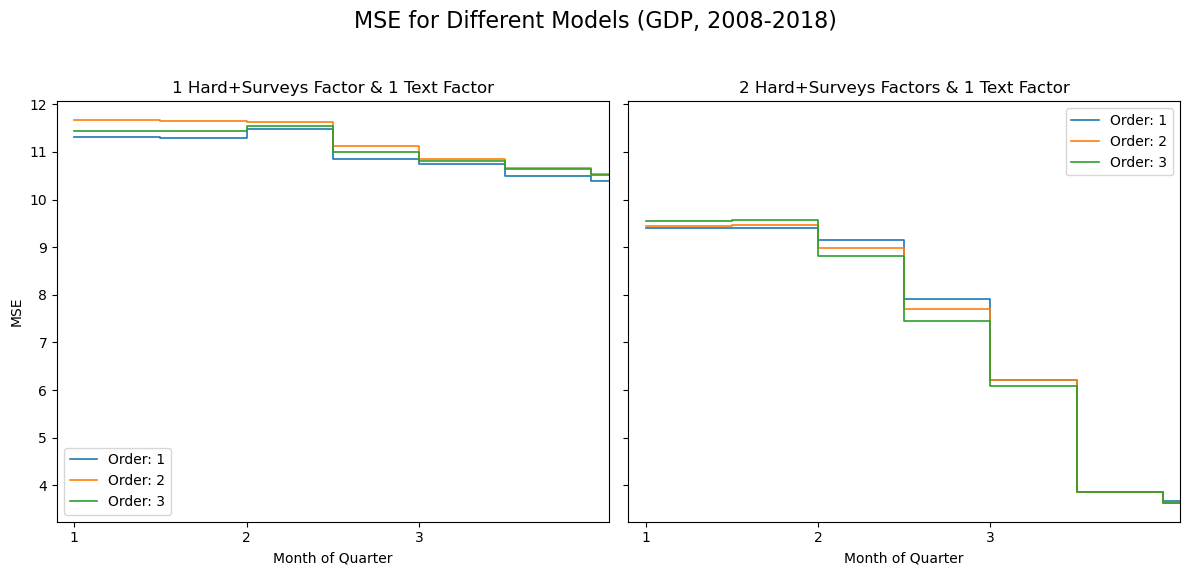

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'GDP'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


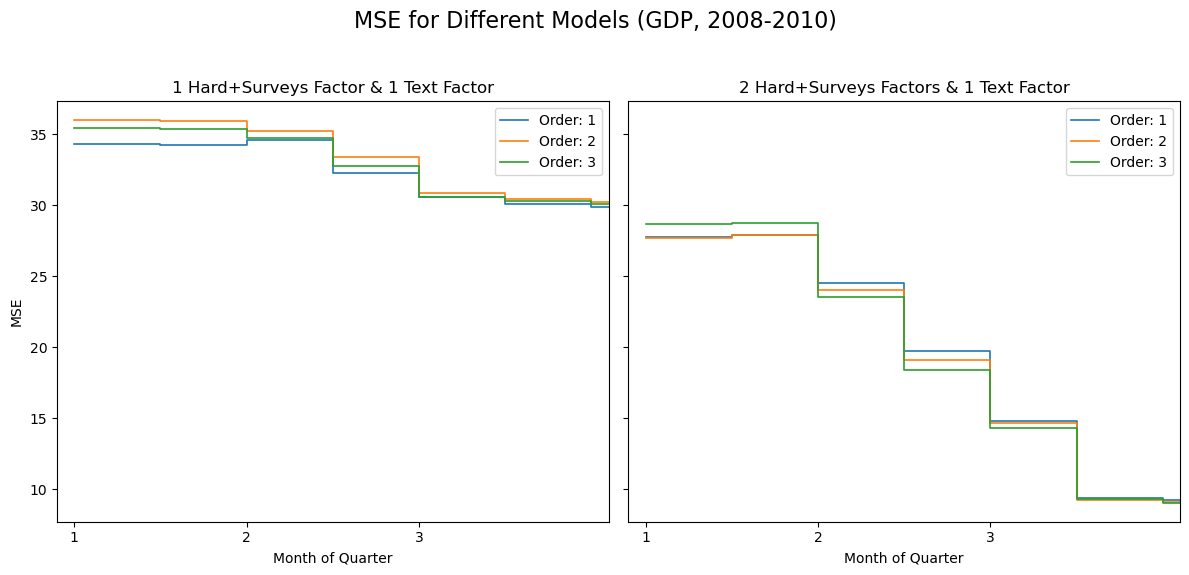

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


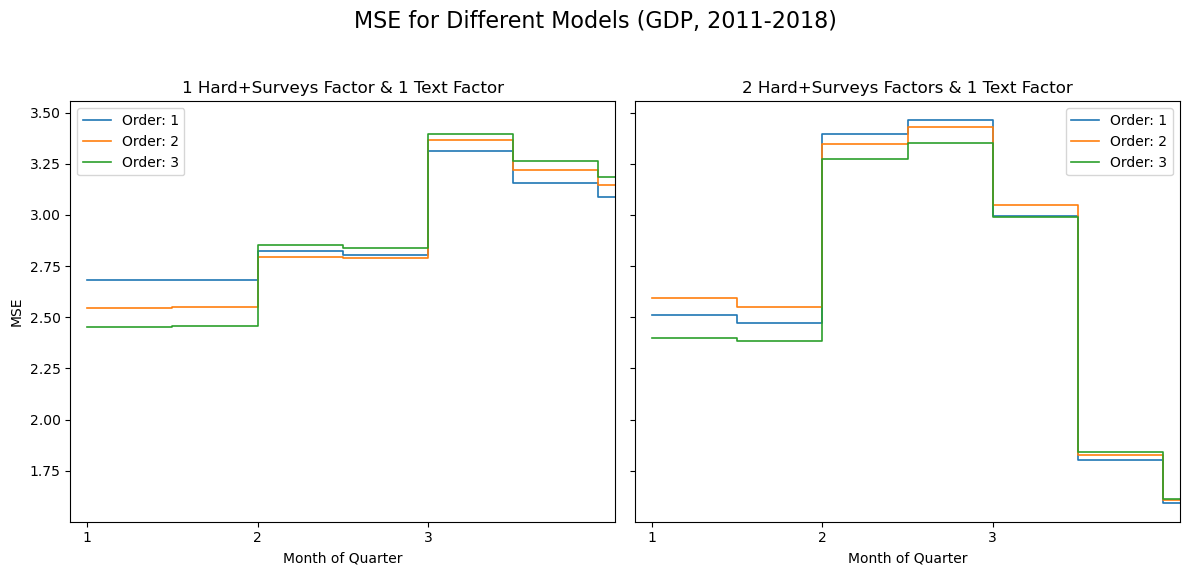

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_GDP_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


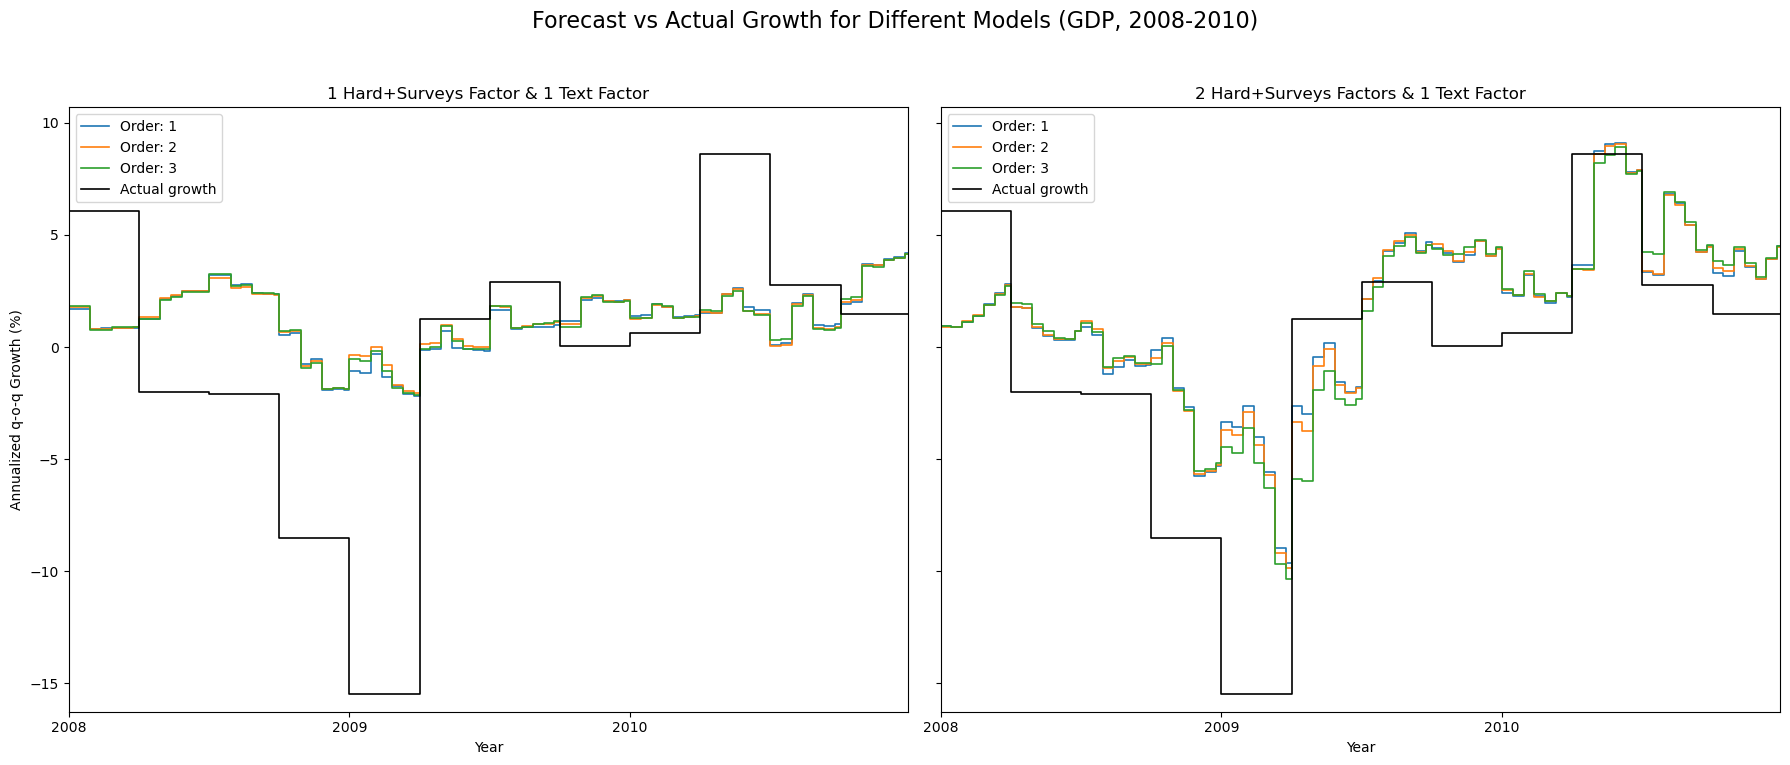

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


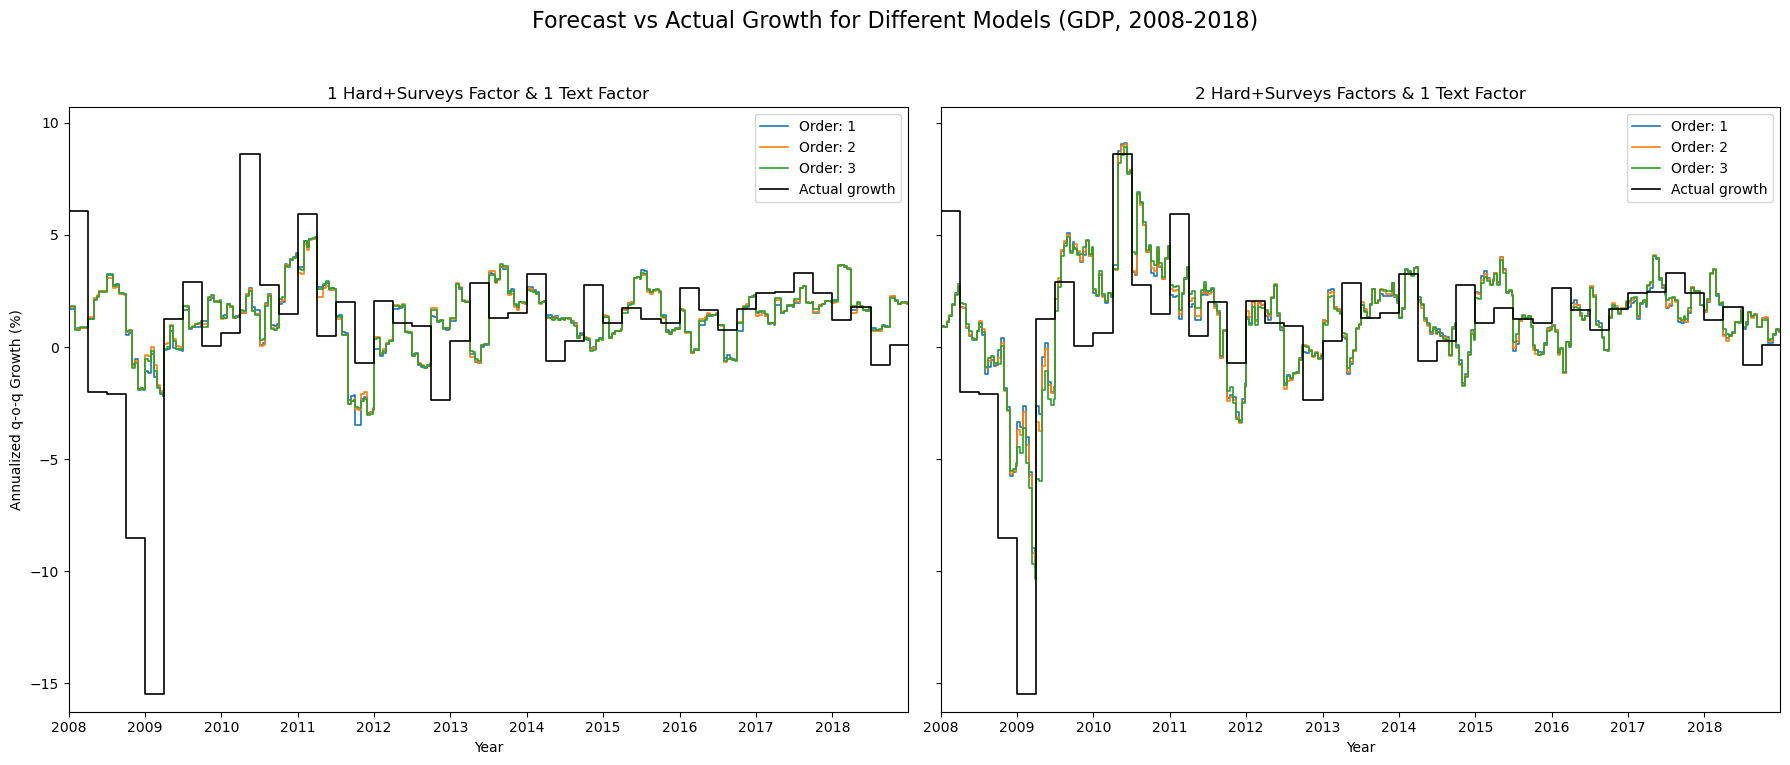

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


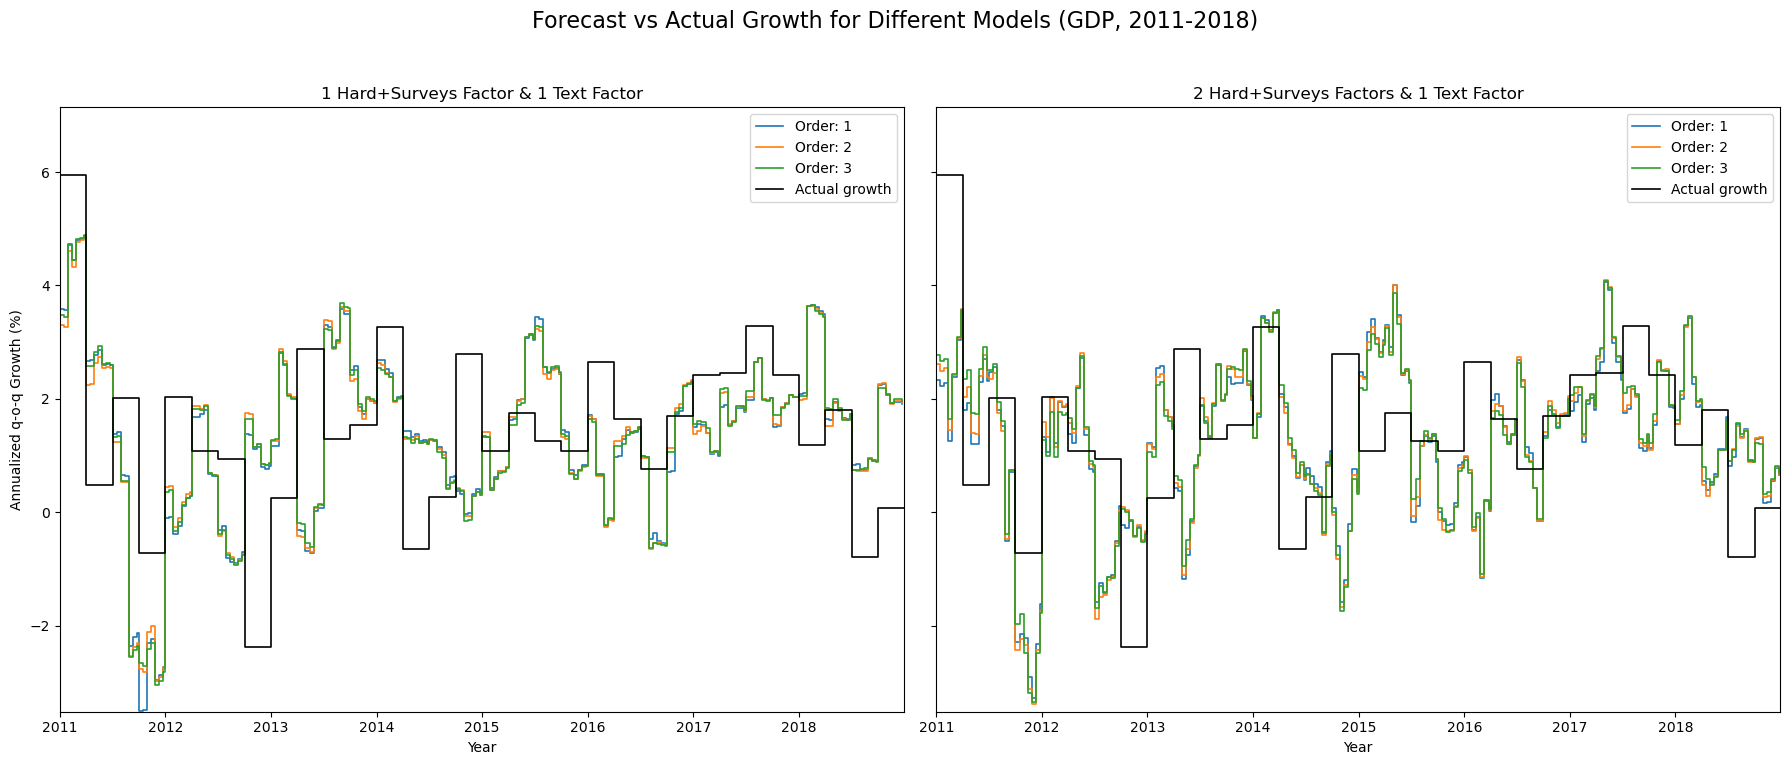

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_GDP_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()